# Deep Learning

<a target="_blank" href="https://colab.research.google.com/github/intro-stat-learning/ISLP_labs/blob/v2.2/Ch10-deeplearning-lab.ipynb">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/intro-stat-learning/ISLP_labs/v2.2?labpath=Ch10-deeplearning-lab.ipynb)

In this section we  demonstrate how to fit the examples discussed
in the text. We use the `Python`{} `torch` package, along with the
`pytorch_lightning` package which provides utilities to simplify
fitting and evaluating models.  This code can be impressively fast
with certain  special processors,  such as Apple’s new M1 chip. The package is well-structured, flexible, and will feel comfortable
to `Python`{} users. A good companion is the site
[pytorch.org/tutorials](https://pytorch.org/tutorials/beginner/basics/intro.html).
Much of our code is adapted from there, as well as the `pytorch_lightning` documentation. {The precise URLs at the time of writing are <https://pytorch.org/tutorials/beginner/basics/intro.html> and <https://pytorch-lightning.readthedocs.io/en/latest/>.}

We start with several standard imports that we have  seen before.

In [13]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
from sklearn.linear_model import \
     (LinearRegression,
      LogisticRegression,
      Lasso)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from sklearn.model_selection import \
     (train_test_split,
      GridSearchCV)

### Torch-Specific Imports
There are a number of imports for `torch`. (These are not
included with `ISLP`, so must be installed separately.)
First we import the main library
and essential tools used to specify sequentially-structured networks.

In [14]:
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset


There are several other helper packages for `torch`. For instance,
the `torchmetrics` package has utilities to compute
various metrics to evaluate performance when fitting
a model. The `torchinfo` package provides a useful
summary of the layers of a model. We use the `read_image()`
function when loading test images in Section~\ref{Ch13-deeplearning-lab:using-pretrained-cnn-models}.

If you have not already installed the packages `torchvision`
and `torchinfo` you can install them by running
`pip install torchinfo torchvision`.
We can now import from `torchinfo`.


In [15]:
from torchmetrics import (MeanAbsoluteError,
                          R2Score)
from torchinfo import summary


The package `pytorch_lightning` is a somewhat higher-level
interface to `torch` that simplifies the specification and
fitting of
models by reducing the amount of boilerplate code needed
(compared to using `torch` alone).

In [16]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger


In order to reproduce results we use `seed_everything()`. We will also instruct `torch` to use deterministic algorithms
where possible.

In [17]:
from pytorch_lightning import seed_everything
seed_everything(0, workers=True)
torch.use_deterministic_algorithms(True, warn_only=True)


Seed set to 0


We will use several datasets shipped with `torchvision` for our
examples: a pretrained network for image classification,
as well as some transforms used for preprocessing.

In [18]:
from torchvision.io import read_image
from torchvision.datasets import MNIST, CIFAR100
from torchvision.models import (resnet50,
                                ResNet50_Weights)
from torchvision.transforms import (Resize,
                                    Normalize,
                                    CenterCrop,
                                    ToTensor)

We have provided a few utilities in `ISLP` specifically for this lab.
The `SimpleDataModule` and `SimpleModule` are simple
versions of objects used in `pytorch_lightning`, the
high-level module for fitting `torch` models. Although more advanced
uses such as computing on graphical processing units (GPUs) and parallel data processing
are possible in this module, we will not be focusing much on these
in this lab. The `ErrorTracker` handles
collections of targets and predictions over each mini-batch
in the validation or test stage, allowing computation
of the metric over the entire validation or test data set.

In [19]:
from ISLP.torch import (SimpleDataModule,
                        SimpleModule,
                        ErrorTracker,
                        rec_num_workers)


In addition we have included some helper
functions to load the
`IMDb` database, as well as a lookup that maps integers
to particular keys in the database. We’ve included
a slightly modified copy of the preprocessed
`IMDb` data from `keras`, a separate package
for fitting deep learning models. This saves us significant
preprocessing and allows us to focus on specifying and fitting
the models themselves.

In [20]:
from ISLP.torch.imdb import (load_lookup,
                             load_tensor,
                             load_sparse,
                             load_sequential)


Finally, we introduce some utility imports  not directly related to
`torch`.
The `glob()` function from the `glob` module is used
to find all files matching wildcard characters, which we will use
in our example applying the `ResNet50` model
to some of our own images.
The `json` module will be used to load
a JSON file for looking up classes to identify the labels of the
pictures in the `ResNet50` example.

In [21]:
from glob import glob
import json


## Single Layer Network on Hitters Data
We start by fitting the models in Section~\ref{Ch13:sec:when-use-deep} on the `Hitters` data.

In [22]:
Hitters = load_data('Hitters').dropna()
n = Hitters.shape[0]


 We will fit two linear models (least squares  and lasso) and  compare their performance
to that of a neural network. For this comparison we will use mean absolute error on a validation dataset.
\begin{equation*}
\begin{split}
\mbox{MAE}(y,\hat{y}) = \frac{1}{n} \sum_{i=1}^n |y_i-\hat{y}_i|.
\end{split}
\end{equation*}
We set up the model matrix and the response.

In [23]:
model = MS(Hitters.columns.drop('Salary'), intercept=False)
X = model.fit_transform(Hitters).to_numpy()
Y = Hitters['Salary'].to_numpy()


The `to_numpy()`  method above converts `pandas`
data frames or series to `numpy` arrays.
We do this because we will need to  use `sklearn` to fit the lasso model,
and it requires this conversion. 
We also use  a linear regression method from `sklearn`, rather than the method
in Chapter~3 from `statsmodels`, to facilitate the comparisons.

We now split the data into test and training, fixing the random
state used by `sklearn` to do the split.

In [24]:
(X_train, 
 X_test,
 Y_train,
 Y_test) = train_test_split(X,
                            Y,
                            test_size=1/3,
                            random_state=1)

### Linear Models
We fit the linear model and evaluate the test error directly.

In [25]:
hit_lm = LinearRegression().fit(X_train, Y_train)
Yhat_test = hit_lm.predict(X_test)
np.abs(Yhat_test - Y_test).mean()

259.71528833146243

Next we fit the lasso using `sklearn`. We are using
mean absolute error to select and evaluate a model, rather than mean squared error.
The specialized solver we used in Section~\ref{Ch6-varselect-lab:lab-2-ridge-regression-and-the-lasso} uses only mean squared error. So here, with a bit more work,  we create a cross-validation grid and perform the cross-validation directly.  

We encode a pipeline with two steps: we first normalize the features using a `StandardScaler()` transform,
and then fit the lasso without further normalization. 

In [26]:
scaler = StandardScaler(with_mean=True, with_std=True)
lasso = Lasso(warm_start=True, max_iter=30000)
standard_lasso = Pipeline(steps=[('scaler', scaler),
                                 ('lasso', lasso)])

We need to create a grid of values for $\lambda$. As is common practice, 
we choose a grid of 100 values of $\lambda$, uniform on the log scale from `lam_max` down to  `0.01*lam_max`. Here  `lam_max` is the smallest value of
$\lambda$ with an  all-zero solution. This value equals the largest absolute inner-product between any predictor and the (centered) response. {The derivation of this result is beyond the scope of this book.}

In [27]:
X_s = scaler.fit_transform(X_train)
n = X_s.shape[0]
lam_max = np.fabs(X_s.T.dot(Y_train - Y_train.mean())).max() / n
param_grid = {'lasso__alpha': np.exp(np.linspace(0, np.log(0.01), 100))
             * lam_max}

Note that we had to transform the data first, since the scale of the variables impacts the choice of $\lambda$.
We now perform cross-validation using this sequence of $\lambda$ values.

In [28]:
cv = KFold(10,
           shuffle=True,
           random_state=1)
grid = GridSearchCV(standard_lasso,
                    param_grid,
                    cv=cv,
                    scoring='neg_mean_absolute_error')
grid.fit(X_train, Y_train);

We extract the lasso model with best cross-validated mean absolute error, and evaluate its
performance on `X_test` and `Y_test`, which were not used in
cross-validation.

In [29]:
trained_lasso = grid.best_estimator_
Yhat_test = trained_lasso.predict(X_test)
np.fabs(Yhat_test - Y_test).mean()

235.67548374780287

This is similar to the results we got for the linear model fit by least squares. However, these results can vary a lot for different train/test splits; we encourage the reader to try a different seed in code block 12 and rerun the subsequent code up to this point.

### Specifying a Network: Classes and Inheritance
To fit the neural network, we first set up a model structure
that describes the network.
Doing so requires us to define new classes specific to the model we wish to fit.
Typically this is done in  `pytorch` by sub-classing a generic
representation of a network, which is the approach we take here.
Although this example is simple, we will go through the steps in some detail, since it will serve us well
for the more complex examples to follow.


In [30]:
class HittersModel(nn.Module):

    def __init__(self, input_size):
        super(HittersModel, self).__init__()
        self.flatten = nn.Flatten()
        self.sequential = nn.Sequential(
            nn.Linear(input_size, 50),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(50, 1))

    def forward(self, x):
        x = self.flatten(x)
        return torch.flatten(self.sequential(x))


The `class` statement identifies the code chunk as a
declaration for a class `HittersModel`
that inherits from the  base class `nn.Module`. This base
class is ubiquitous in `torch` and represents the
mappings in the neural networks.

Indented beneath the `class` statement are the methods of this class:
in this case `__init__` and `forward`.  The `__init__` method is
called when an instance of the class is created as in the cell
below. In the methods, `self` always refers to an instance of the
class. In the `__init__` method, we have attached two objects to
`self` as attributes: `flatten` and `sequential`. These are used in
the `forward` method to describe the map that this module implements.

There is one additional line in the `__init__` method, which
is a call to
`super()`. This function allows subclasses (i.e. `HittersModel`)
to access methods of the class they inherit from. For example,
the class `nn.Module` has its own `__init__` method, which is different from
the `HittersModel.__init__()` method we’ve written above.
Using `super()` allows us to call the method of the base class. For
`torch` models, we will always be making this `super()` call as it is necessary
for the model to be properly interpreted by `torch`.

The object `nn.Module` has more methods than simply `__init__` and `forward`. These
methods are directly accessible to `HittersModel` instances because of this inheritance.
One such method we will see shortly is the `eval()` method, used
to disable dropout for when we want to evaluate the model on test data.

In [31]:
hit_model = HittersModel(X.shape[1])


The object `self.sequential` is a composition of four maps. The
first maps the 19 features of `Hitters` to 50 dimensions, introducing $50\times 19+50$ parameters
for the weights and *intercept*  of the map (often called the *bias*). This layer
is then mapped to a ReLU layer followed by a 40% dropout layer, and finally a
linear map down to 1 dimension, again with a bias. The total number of
trainable parameters is therefore $50\times 19+50+50+1=1051$.

    

The package `torchinfo` provides a `summary()` function that neatly summarizes
this information. We specify the size of the input and see the size
of each tensor as it passes through layers of the network. 

In [32]:
summary(hit_model, 
        input_size=X_train.shape,
        col_names=['input_size',
                   'output_size',
                   'num_params'])


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
HittersModel                             [175, 19]                 [175]                     --
├─Flatten: 1-1                           [175, 19]                 [175, 19]                 --
├─Sequential: 1-2                        [175, 19]                 [175, 1]                  --
│    └─Linear: 2-1                       [175, 19]                 [175, 50]                 1,000
│    └─ReLU: 2-2                         [175, 50]                 [175, 50]                 --
│    └─Dropout: 2-3                      [175, 50]                 [175, 50]                 --
│    └─Linear: 2-4                       [175, 50]                 [175, 1]                  51
Total params: 1,051
Trainable params: 1,051
Non-trainable params: 0
Total mult-adds (M): 0.18
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 0.00
Estimated Total Size (MB): 0.09

We have truncated the end of the output slightly, here and in subsequent uses.

We now need to transform our training data into a form accessible to `torch`.
The basic
datatype in `torch` is a `tensor`, which is very similar
to an `ndarray` from early chapters.
We also note here that `torch` typically
works with 32-bit (*single precision*)
rather than 64-bit (*double precision*) floating point numbers.
We therefore convert our data to `np.float32` before
forming the tensor.
The $X$ and $Y$ tensors are then arranged into a `Dataset`
recognized by `torch`
using `TensorDataset()`.

In [33]:
X_train_t = torch.tensor(X_train.astype(np.float32))
Y_train_t = torch.tensor(Y_train.astype(np.float32))
hit_train = TensorDataset(X_train_t, Y_train_t)

We do the same for the test data.

In [34]:
X_test_t = torch.tensor(X_test.astype(np.float32))
Y_test_t = torch.tensor(Y_test.astype(np.float32))
hit_test = TensorDataset(X_test_t, Y_test_t)


Finally, this dataset is passed to a `DataLoader()` which ultimately
passes data into our network. While this may seem
like a lot of overhead, this structure is helpful for more
complex tasks where data may live on different machines,
or where data must be passed to a GPU.
We provide a helper function `SimpleDataModule()` in `ISLP` to make this task easier for
standard usage.
One of its arguments is `num_workers`, which indicates
how many processes we will use
for loading the data. For small
data like `Hitters` this will have little effect, but
it does provide an advantage for the `MNIST`  and `CIFAR100` examples below.
The `torch` package will inspect the process running and determine a
maximum number of workers. {This depends on the computing hardware and the number of cores available.} We’ve included a function
`rec_num_workers()` to compute this so we know how many
workers might be reasonable (here the max was 16).

In [35]:
max_num_workers = rec_num_workers()

The general training setup in `pytorch_lightning` involves
training, validation and test data. These are each
represented by different data loaders. During each epoch,
we run a training step to learn the model and a validation
step to track the error. The test data is typically
used at the end of training to evaluate the model.

In this case, as we had split only into test and training,
we’ll use the test data as validation data with the
argument `validation=hit_test`. The
`validation` argument can be a float between 0 and 1, an
integer, or a
`Dataset`. If a float (respectively, integer), it is interpreted
as a percentage (respectively number) of the *training* observations to be used for validation.
If it is a `Dataset`, it is passed directly to a data loader.

In [36]:
hit_dm = SimpleDataModule(hit_train,
                          hit_test,
                          batch_size=32,
                          num_workers=min(4, max_num_workers),
                          validation=hit_test)


Next we must provide a `pytorch_lightning` module that controls
the steps performed during the training process. We provide methods for our
`SimpleModule()` that simply record the value
of the loss function and any additional
metrics at the end of each epoch. These operations
are controlled by the methods `SimpleModule.[training/test/validation]_step()`, though
we will not be modifying these in our examples.

In [37]:
hit_module = SimpleModule.regression(hit_model,
                           metrics={'mae':MeanAbsoluteError()})


 By using the `SimpleModule.regression()` method,  we indicate that we will use squared-error loss as in
(\ref{Ch13:eq:4}).
We have also asked for mean absolute error to be tracked as well
in the metrics that are logged.

We log our results via `CSVLogger()`, which in this case stores the results in a CSV file within a directory `logs/hitters`. After the fitting is complete, this allows us to load the
results as a `pd.DataFrame()` and visualize them below. There are
several ways to log the results within `pytorch_lightning`, though
we will not cover those here in detail.

In [38]:
hit_logger = CSVLogger('logs', name='hitters')

Finally we are ready to train our model and log the results. We
use the `Trainer()` object from `pytorch_lightning`
to do this work. The argument `datamodule=hit_dm` tells the trainer
how training/validation/test logs are produced,
while the first argument `hit_module`
specifies the network architecture
as well as the training/validation/test steps.
The `callbacks` argument allows for
several tasks to be carried out at various
points while training a model. Here
our `ErrorTracker()` callback will enable
us to compute validation error while training
and, finally, the test error.
We now fit the model for 50 epochs.

In [39]:
hit_trainer = Trainer(deterministic=True,
                      max_epochs=50,
                      log_every_n_steps=5,
                      logger=hit_logger,
                      callbacks=[ErrorTracker()])
hit_trainer.fit(hit_module, datamodule=hit_dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/hitters

  | Name  | Type         | Params
---------------------------------------
0 | model | HittersModel | 1.1 K 
1 | loss  | MSELoss      | 0     
---------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 184.04it/s, v_num=0]           

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 6/6 [00:00<00:00, 164.01it/s, v_num=0]


At each step of SGD, the algorithm randomly selects 32 training observations for
the computation of the gradient. Recall from Section~\ref{Ch13:sec:fitt-neur-netw}
that an epoch amounts to the number of SGD steps required to process $n$
observations. Since the training set has
$n=175$, and we specified a `batch_size` of 32 in the construction of  `hit_dm`, an epoch is $175/32=5.5$ SGD steps.

After having fit the model, we can evaluate performance on our test
data using the `test()` method of our trainer.

In [40]:
hit_trainer.test(hit_module, datamodule=hit_dm)


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 157.50it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss             107904.6484375
        test_mae            221.83148193359375
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 107904.6484375, 'test_mae': 221.83148193359375}]

The results of the fit have been logged into a CSV file. We can find the
results specific to this run in the `experiment.metrics_file_path`
attribute of our logger. Note that each time the model is fit, the logger will output
results into a new subdirectory of our directory `logs/hitters`.

We now create a plot of the MAE (mean absolute error) as a function of
the number of epochs.
First we retrieve the logged summaries.

In [41]:
hit_results = pd.read_csv(hit_logger.experiment.metrics_file_path)

Since we will produce similar plots in later examples, we write a
simple generic function to produce this plot.

In [42]:
def summary_plot(results,
                 ax,
                 col='loss',
                 valid_legend='Validation',
                 training_legend='Training',
                 ylabel='Loss',
                 fontsize=20):
    for (column,
         color,
         label) in zip([f'train_{col}_epoch',
                        f'valid_{col}'],
                       ['black',
                        'red'],
                       [training_legend,
                        valid_legend]):
        results.plot(x='epoch',
                     y=column,
                     label=label,
                     marker='o',
                     color=color,
                     ax=ax)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel)
    return ax

We now set up our axes, and use our function to produce the MAE plot.

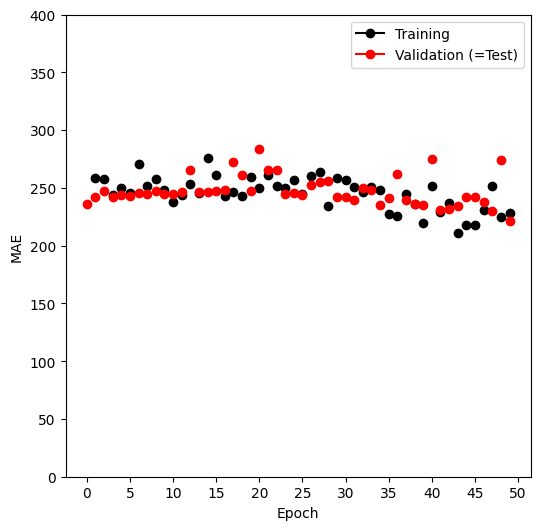

In [43]:
fig, ax = subplots(1, 1, figsize=(6, 6))
ax = summary_plot(hit_results,
                  ax,
                  col='mae',
                  ylabel='MAE',
                  valid_legend='Validation (=Test)')
ax.set_ylim([0, 400])
ax.set_xticks(np.linspace(0, 50, 11).astype(int));

We can predict directly from the final model, and
evaluate its performance on the test data.
Before fitting, we call the `eval()` method
of `hit_model`.
This tells
`torch` to effectively consider this model to be fitted, so that
we can use it to predict on new data. For our model here,
the biggest change is that the dropout layers will
be turned off, i.e. no weights will be randomly
dropped in predicting on new data.

In [44]:
hit_model.eval() 
preds = hit_module(X_test_t)
torch.abs(Y_test_t - preds).mean()

tensor(221.8315, grad_fn=<MeanBackward0>)

### Cleanup
In setting up our data module, we had initiated
several worker processes that will remain running.
We delete all references to the torch objects to ensure these processes
will be killed.
 

In [45]:
del(Hitters,
    hit_model, hit_dm,
    hit_logger,
    hit_test, hit_train,
    X, Y,
    X_test, X_train,
    Y_test, Y_train,
    X_test_t, Y_test_t,
    hit_trainer, hit_module)


## Multilayer Network on the MNIST Digit Data
The `torchvision` package comes with a number of example datasets,
including the `MNIST`  digit data. Our first step is to retrieve
the training and test data sets; the `MNIST()` function within
`torchvision.datasets` is provided for this purpose. The
data will be downloaded the first time this function is executed, and stored in the directory `data/MNIST`.

In [46]:
(mnist_train, 
 mnist_test) = [MNIST(root='data',
                      train=train,
                      download=True,
                      transform=ToTensor())
                for train in [True, False]]
mnist_train


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:02<00:00, 4384566.26it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 369881.11it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:00<00:00, 3075409.37it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 908422.52it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

There are 60,000 images in the training data and 10,000 in the test
data. The images are $28\times 28$, and stored as a matrix of pixels. We
need to transform each one into a vector.

Neural networks are somewhat sensitive to the scale of the inputs, much as ridge and
lasso regularization are affected by scaling.  Here the inputs are eight-bit
grayscale values between 0 and 255, so we rescale to the unit
interval. {Note: eight bits means $2^8$, which equals 256. Since the convention
is to start at $0$, the possible values  range from $0$ to $255$.}
This transformation, along with some reordering
of the axes, is performed by the `ToTensor()` transform
from the `torchvision.transforms` package.

As in our `Hitters` example, we form a data module
from the training and test datasets, setting aside 20%
of the training images for validation.

In [47]:
mnist_dm = SimpleDataModule(mnist_train,
                            mnist_test,
                            validation=0.2,
                            num_workers=max_num_workers,
                            batch_size=256)


Let’s take a look at the data that will get fed into our network. We loop through the first few
chunks of the test dataset, breaking after 2 batches:

In [48]:
for idx, (X_ ,Y_) in enumerate(mnist_dm.train_dataloader()):
    print('X: ', X_.shape)
    print('Y: ', Y_.shape)
    if idx >= 1:
        break


X:  torch.Size([256, 1, 28, 28])
Y:  torch.Size([256])
X:  torch.Size([256, 1, 28, 28])
Y:  torch.Size([256])


We see that the $X$ for each batch consists of 256 images of size `1x28x28`.
Here the `1` indicates a single channel (greyscale). For RGB images such as `CIFAR100` below,
we will see that the `1` in the size will be replaced by `3` for the three RGB channels.

Now we are ready to specify our neural network.

In [49]:
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Dropout(0.4))
        self.layer2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3))
        self._forward = nn.Sequential(
            self.layer1,
            self.layer2,
            nn.Linear(128, 10))
    def forward(self, x):
        return self._forward(x)

We see that in the first layer, each `1x28x28` image is flattened, then mapped to
256 dimensions where we apply a ReLU activation with 40% dropout.
A second layer maps the first layer’s output down to
128 dimensions, applying a ReLU activation with 30% dropout. Finally,
the 128 dimensions are mapped down to 10, the number of classes in the
`MNIST`  data.

In [50]:
mnist_model = MNISTModel()


We can check that the model produces output of expected size based
on our existing batch `X_` above.

In [51]:
mnist_model(X_).size()

torch.Size([256, 10])

Let’s take a look at the summary of the model. Instead of an `input_size` we can pass
a tensor of correct shape. In this case, we pass through the final
batched `X_` from above.

In [52]:
summary(mnist_model,
        input_data=X_,
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
MNISTModel                               [256, 1, 28, 28]          [256, 10]                 --
├─Sequential: 1-1                        [256, 1, 28, 28]          [256, 10]                 --
│    └─Sequential: 2-1                   [256, 1, 28, 28]          [256, 256]                --
│    │    └─Flatten: 3-1                 [256, 1, 28, 28]          [256, 784]                --
│    │    └─Linear: 3-2                  [256, 784]                [256, 256]                200,960
│    │    └─ReLU: 3-3                    [256, 256]                [256, 256]                --
│    │    └─Dropout: 3-4                 [256, 256]                [256, 256]                --
│    └─Sequential: 2-2                   [256, 256]                [256, 128]                --
│    │    └─Linear: 3-5                  [256, 256]                [256, 128]                32,896
│    │    └─ReLU: 3-6     

Having set up both  the model and the data module, fitting this model is
now almost identical to the `Hitters` example. In contrast to our regression model, here we will use the
`SimpleModule.classification()` method which
uses the  cross-entropy loss function instead of mean squared error. It must be supplied with the number of
classes in the problem.

In [53]:
mnist_module = SimpleModule.classification(mnist_model,
                                           num_classes=10)
mnist_logger = CSVLogger('logs', name='MNIST')


Now we are ready to go. The final step is to supply training data, and fit the model. We disable the progress bar below to avoid lengthy output in the browser when running.

In [54]:
mnist_trainer = Trainer(deterministic=True,
                        max_epochs=30,
                        logger=mnist_logger,
                        enable_progress_bar=False,
                        callbacks=[ErrorTracker()])
mnist_trainer.fit(mnist_module,
                  datamodule=mnist_dm)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/MNIST

  | Name  | Type             | Params
-------------------------------------------
0 | model | MNISTModel       | 235 K 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
235 K     Trainable params
0         Non-trainable params
235 K     Total params
0.941     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=30` reached.


We have suppressed the output here, which is a progress report on the
fitting of the model, grouped by epoch. This is very useful, since on
large datasets fitting can take time. Fitting this model took 245
seconds on a MacBook Pro with an Apple M1 Pro chip with 10 cores and 16 GB of RAM.
Here we specified a
validation split of 20%, so training is actually performed on
80% of the 60,000 observations in the training set. This is an
alternative to actually supplying validation data, like we did for the `Hitters` data.
SGD  uses batches
of 256 observations in computing the gradient, and doing the
arithmetic, we see that an epoch corresponds to 188 gradient steps.

`SimpleModule.classification()` includes
an accuracy metric by default. Other
classification metrics can be added from `torchmetrics`.
We will use  our `summary_plot()` function to display 
accuracy across epochs.

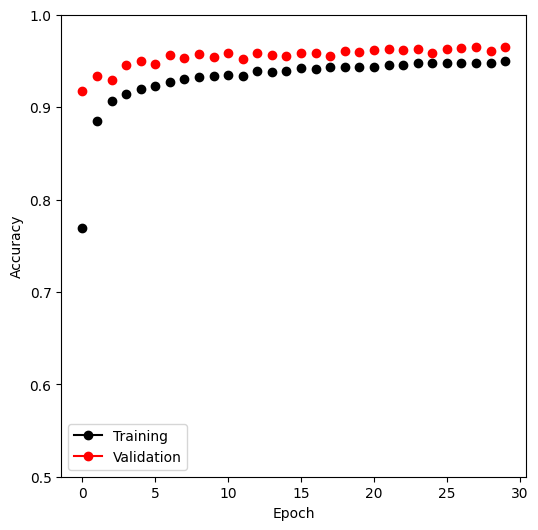

In [55]:
mnist_results = pd.read_csv(mnist_logger.experiment.metrics_file_path)
fig, ax = subplots(1, 1, figsize=(6, 6))
summary_plot(mnist_results,
             ax,
             col='accuracy',
             ylabel='Accuracy')
ax.set_ylim([0.5, 1])
ax.set_ylabel('Accuracy')
ax.set_xticks(np.linspace(0, 30, 7).astype(int));


Once again we evaluate the accuracy using the `test()` method of our trainer. This model achieves
97% accuracy on the test data.

In [56]:
mnist_trainer.test(mnist_module,
                   datamodule=mnist_dm)

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9642000198364258
        test_loss           0.14285090565681458
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.14285090565681458, 'test_accuracy': 0.9642000198364258}]

Table~\ref{Ch13:tab:mnist} also reports the error rates resulting from LDA (Chapter~\ref{Ch4:classification}) and multiclass logistic
regression. For LDA we refer the reader to Section~\ref{Ch4-classification-lab:linear-discriminant-analysis}.
Although we could use the `sklearn` function `LogisticRegression()` to fit  
multiclass logistic regression, we are set up here to fit such a model
with `torch`.
We just have an input layer and an output layer, and omit the hidden layers!

In [57]:
class MNIST_MLR(nn.Module):
    def __init__(self):
        super(MNIST_MLR, self).__init__()
        self.linear = nn.Sequential(nn.Flatten(),
                                    nn.Linear(784, 10))
    def forward(self, x):
        return self.linear(x)

mlr_model = MNIST_MLR()
mlr_module = SimpleModule.classification(mlr_model,
                                         num_classes=10)
mlr_logger = CSVLogger('logs', name='MNIST_MLR')

In [58]:
mlr_trainer = Trainer(deterministic=True,
                      max_epochs=30,
                      enable_progress_bar=False,
                      callbacks=[ErrorTracker()])
mlr_trainer.fit(mlr_module, datamodule=mnist_dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/envs/islp-dl/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
Missing logger folder: /Users/mendible/Downloads/lightning_logs

  | Name  | Type             | Params
-------------------------------------------
0 | model | MNIST_MLR        | 7.9 K 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
7.9 K     Trainable params
0         Non-t

We fit the model just as before and compute the test results.

In [59]:
mlr_trainer.test(mlr_module,
                 datamodule=mnist_dm)

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          0.916100025177002
        test_loss            0.346929669380188
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.346929669380188, 'test_accuracy': 0.916100025177002}]

The accuracy is above 90% even for this pretty simple model.

As in the `Hitters` example, we delete some of
the objects we created above.

In [60]:
del(mnist_test,
    mnist_train,
    mnist_model,
    mnist_dm,
    mnist_trainer,
    mnist_module,
    mnist_results,
    mlr_model,
    mlr_module,
    mlr_trainer)

## Convolutional Neural Networks
In this section we fit a CNN to the `CIFAR100` data, which is available in the `torchvision`
package. It is arranged in a similar fashion as the `MNIST` data.

In [61]:
(cifar_train, 
 cifar_test) = [CIFAR100(root="data",
                         train=train,
                         download=True)
             for train in [True, False]]

100%|██████████| 169001437/169001437 [00:27<00:00, 6119085.47it/s]


Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified


In [62]:
transform = ToTensor()
cifar_train_X = torch.stack([transform(x) for x in
                            cifar_train.data])
cifar_test_X = torch.stack([transform(x) for x in
                            cifar_test.data])
cifar_train = TensorDataset(cifar_train_X,
                            torch.tensor(cifar_train.targets))
cifar_test = TensorDataset(cifar_test_X,
                            torch.tensor(cifar_test.targets))

The `CIFAR100` dataset consists of 50,000 training images, each represented by a three-dimensional tensor:
each three-color image is represented as a set of three channels, each of which consists of
$32\times 32$ eight-bit pixels. We standardize as we did for the
digits, but keep the array structure. This is accomplished with the `ToTensor()` transform.

Creating the data module is similar to the `MNIST`  example.

In [63]:
cifar_dm = SimpleDataModule(cifar_train,
                            cifar_test,
                            validation=0.2,
                            num_workers=max_num_workers,
                            batch_size=128)


We again look at the shape of typical batches in our data loaders.

In [64]:
for idx, (X_ ,Y_) in enumerate(cifar_dm.train_dataloader()):
    print('X: ', X_.shape)
    print('Y: ', Y_.shape)
    if idx >= 1:
        break


X:  torch.Size([128, 3, 32, 32])
Y:  torch.Size([128])
X:  torch.Size([128, 3, 32, 32])
Y:  torch.Size([128])


Before we start, we look at some of the training images; similar code produced
Figure~\ref{Ch13:fig:cifar100} on page \pageref{Ch13:fig:cifar100}. The example below also illustrates
that `TensorDataset` objects can be indexed with integers --- we are choosing
random images from the training data by indexing `cifar_train`. In order to display correctly,
we must reorder the dimensions by a call to `np.transpose()`.

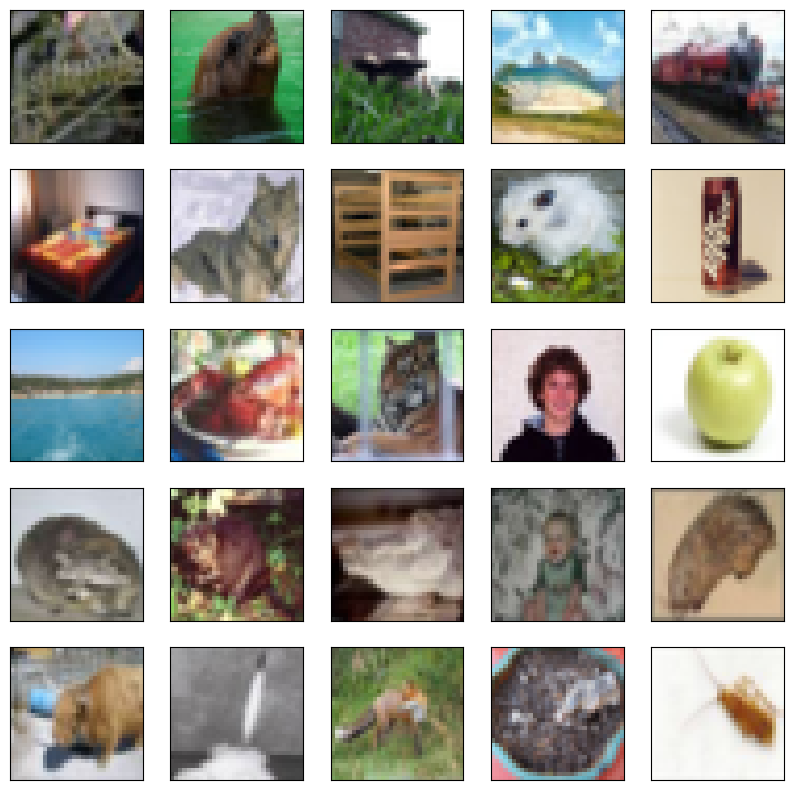

In [65]:
fig, axes = subplots(5, 5, figsize=(10,10))
rng = np.random.default_rng(4)
indices = rng.choice(np.arange(len(cifar_train)), 25,
                     replace=False).reshape((5,5))
for i in range(5):
    for j in range(5):
        idx = indices[i,j]
        axes[i,j].imshow(np.transpose(cifar_train[idx][0],
                                      [1,2,0]),
                                      interpolation=None)
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])


Here the `imshow()` method recognizes from the shape of its argument that it is a 3-dimensional array, with the last dimension indexing the three RGB color channels.

We specify a moderately-sized  CNN for
demonstration purposes, similar in structure to Figure~\ref{Ch13:fig:DeepCNN}.
We use several layers, each consisting of  convolution, ReLU, and max-pooling steps.
We first define a module that defines one of these layers. As in our
previous examples, we overwrite the `__init__()` and `forward()` methods
of `nn.Module`. This user-defined  module can now be used in ways just like
`nn.Linear()` or `nn.Dropout()`.

In [66]:
class BuildingBlock(nn.Module):

    def __init__(self,
                 in_channels,
                 out_channels):

        super(BuildingBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels,
                              out_channels=out_channels,
                              kernel_size=(3,3),
                              padding='same')
        self.activation = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=(2,2))

    def forward(self, x):
        return self.pool(self.activation(self.conv(x)))


Notice that we used the `padding = "same"` argument to
`nn.Conv2d()`, which ensures that the output channels have the
same dimension as the input channels. There are 32 channels in the first
hidden layer, in contrast to the three channels in the input layer. We
use a $3\times 3$ convolution filter for each channel in all the layers. Each
convolution is followed by a max-pooling layer over $2\times2$
blocks.

In forming our deep learning model for the `CIFAR100` data, we use several of our `BuildingBlock()`
modules sequentially. This simple example
illustrates some of the power of `torch`. Users can
define modules of their own, which can be combined in other
modules. Ultimately, everything is fit by a generic trainer.

In [67]:
class CIFARModel(nn.Module):

    def __init__(self):
        super(CIFARModel, self).__init__()
        sizes = [(3,32),
                 (32,64),
                 (64,128),
                 (128,256)]
        self.conv = nn.Sequential(*[BuildingBlock(in_, out_)
                                    for in_, out_ in sizes])

        self.output = nn.Sequential(nn.Dropout(0.5),
                                    nn.Linear(2*2*256, 512),
                                    nn.ReLU(),
                                    nn.Linear(512, 100))
    def forward(self, x):
        val = self.conv(x)
        val = torch.flatten(val, start_dim=1)
        return self.output(val)


We  build the model and look at the summary. (We had created examples of `X_` earlier.)

In [68]:
cifar_model = CIFARModel()
summary(cifar_model,
        input_data=X_,
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
CIFARModel                               [128, 3, 32, 32]          [128, 100]                --
├─Sequential: 1-1                        [128, 3, 32, 32]          [128, 256, 2, 2]          --
│    └─BuildingBlock: 2-1                [128, 3, 32, 32]          [128, 32, 16, 16]         --
│    │    └─Conv2d: 3-1                  [128, 3, 32, 32]          [128, 32, 32, 32]         896
│    │    └─ReLU: 3-2                    [128, 32, 32, 32]         [128, 32, 32, 32]         --
│    │    └─MaxPool2d: 3-3               [128, 32, 32, 32]         [128, 32, 16, 16]         --
│    └─BuildingBlock: 2-2                [128, 32, 16, 16]         [128, 64, 8, 8]           --
│    │    └─Conv2d: 3-4                  [128, 32, 16, 16]         [128, 64, 16, 16]         18,496
│    │    └─ReLU: 3-5                    [128, 64, 16, 16]         [128, 64, 16, 16]         --
│    │    └─MaxPool2d: 3-6    

The total number of trainable parameters is 964,516.
By studying the size of the parameters, we can see that the channels halve in both
dimensions
after each of these max-pooling operations. After the last of these we
have a layer with  256 channels of dimension $2\times 2$. These are then
flattened to a dense layer of size 1,024;
in other words, each of the $2\times 2$ matrices is turned into a
$4$-vector, and put side-by-side in one layer. This is followed by a
dropout regularization layer,  then
another dense layer of size 512, and finally, the
output layer.

Up to now, we have been using a default
optimizer in `SimpleModule()`. For these data,
experiments show that a smaller learning rate performs
better than the default 0.01. We use a
custom optimizer here with a learning rate of 0.001.
Besides this, the logging and training
follow a similar pattern to our previous examples. The optimizer
takes an argument `params` that informs
the optimizer which parameters are involved in SGD (stochastic gradient descent).

We saw earlier that entries of a module’s parameters are tensors. In passing
the parameters to the optimizer we are doing more than
simply passing arrays; part of the structure of the graph
is encoded in the tensors themselves.

In [69]:
cifar_optimizer = RMSprop(cifar_model.parameters(), lr=0.001)
cifar_module = SimpleModule.classification(cifar_model,
                                    num_classes=100,
                                    optimizer=cifar_optimizer)
cifar_logger = CSVLogger('logs', name='CIFAR100')


In [70]:
cifar_trainer = Trainer(deterministic=True,
                        max_epochs=30,
                        logger=cifar_logger,
                        enable_progress_bar=False,
                        callbacks=[ErrorTracker()])
cifar_trainer.fit(cifar_module,
                  datamodule=cifar_dm)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/CIFAR100

  | Name  | Type             | Params
-------------------------------------------
0 | model | CIFARModel       | 964 K 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
964 K     Trainable params
0         Non-trainable params
964 K     Total params
3.858     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=30` reached.


This model can take 10 minutes or more to run and achieves about 42% accuracy on the test
data. Although this is not terrible for 100-class data (a random
classifier gets 1% accuracy), searching the web we see results around
75%. Typically it takes a lot of architecture carpentry,
fiddling with regularization, and time, to achieve such results.

Let’s take a look at the validation and training accuracy
across epochs.

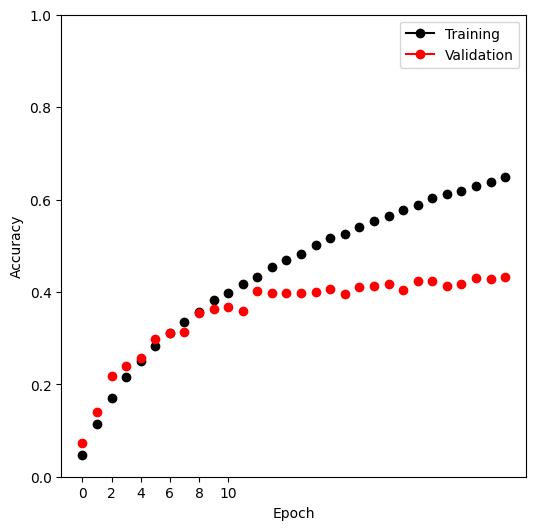

In [71]:
log_path = cifar_logger.experiment.metrics_file_path
cifar_results = pd.read_csv(log_path)
fig, ax = subplots(1, 1, figsize=(6, 6))
summary_plot(cifar_results,
             ax,
             col='accuracy',
             ylabel='Accuracy')
ax.set_xticks(np.linspace(0, 10, 6).astype(int))
ax.set_ylabel('Accuracy')
ax.set_ylim([0, 1]);

Finally, we evaluate our model on our test data.

In [72]:
cifar_trainer.test(cifar_module,
                   datamodule=cifar_dm)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.43050000071525574
        test_loss            2.405660390853882
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 2.405660390853882, 'test_accuracy': 0.43050000071525574}]

### Hardware Acceleration
As deep learning has become ubiquitous in machine learning, hardware
manufacturers have produced special libraries that can
often speed up the gradient-descent steps.

For instance, Mac OS devices with the M1 chip may have the *Metal* programming framework
enabled, which can speed up the  `torch` 
computations. We present an example of how to use this acceleration.

The main changes are to the `Trainer()` call as well as to the metrics
that will be evaluated on the data. These metrics must be told  where
the data will be located at evaluation time. This is
accomplished with a call to the `to()` method of the metrics.

In [73]:
try:
    for name, metric in cifar_module.metrics.items():
        cifar_module.metrics[name] = metric.to('mps')
    cifar_trainer_mps = Trainer(accelerator='mps',
                                deterministic=True,
                                enable_progress_bar=False,
                                max_epochs=30)
    cifar_trainer_mps.fit(cifar_module,
                          datamodule=cifar_dm)
    cifar_trainer_mps.test(cifar_module,
                          datamodule=cifar_dm)
except:
    pass

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params
-------------------------------------------
0 | model | CIFARModel       | 964 K 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
964 K     Trainable params
0         Non-trainable params
964 K     Total params
3.858     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=30` reached.


This yields approximately two- or three-fold  acceleration for each epoch.
We have protected this code block using `try:` and `except:`
clauses; if it works, we get the speedup, if it fails, nothing happens.

## Using Pretrained CNN Models
We now show how to use a CNN pretrained on the  `imagenet` database to classify natural
images, and demonstrate how we produced Figure~\ref{Ch13:fig:homeimages}.
We copied six JPEG images from a digital photo album into the
directory `book_images`. These images are available
from the data section of  <www.statlearning.com>, the ISLP book website. Download `book_images.zip`; when
clicked it creates the `book_images` directory. 

The pretrained network we use is called `resnet50`; specification details can be found on the web.
We will read in the images, and
convert them into the array format expected by the `torch`
software to match the specifications in `resnet50`. 
The conversion involves a resize, a crop and then a predefined standardization for each of the three channels.
We now read in the images and preprocess them.

In [75]:
resize = Resize((232,232), antialias=True)
crop = CenterCrop(224)
normalize = Normalize([0.485,0.456,0.406],
                      [0.229,0.224,0.225])
imgfiles = sorted([f for f in glob('book_images/*')])
imgs = torch.stack([torch.div(crop(resize(read_image(f))), 255)
                    for f in imgfiles])
imgs = normalize(imgs)
imgs.size()

RuntimeError: stack expects a non-empty TensorList

We now set up the trained network with the weights we read in code block~6. The model has 50 layers, with a fair bit of complexity.

In [ ]:
resnet_model = resnet50(weights=ResNet50_Weights.DEFAULT)
summary(resnet_model,
        input_data=imgs,
        col_names=['input_size',
                   'output_size',
                   'num_params'])


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
ResNet                                   [6, 3, 224, 224]          [6, 1000]                 --
├─Conv2d: 1-1                            [6, 3, 224, 224]          [6, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [6, 64, 112, 112]         [6, 64, 112, 112]         128
├─ReLU: 1-3                              [6, 64, 112, 112]         [6, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [6, 64, 112, 112]         [6, 64, 56, 56]           --
├─Sequential: 1-5                        [6, 64, 56, 56]           [6, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [6, 64, 56, 56]           [6, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [6, 64, 56, 56]           [6, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [6, 64, 56, 56]           [6, 64, 56, 56]           128
│    │    └─ReLU: 3-3      

We set the mode to `eval()` to ensure that the model is ready to predict on new data.

In [ ]:
resnet_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Inspecting the output above, we see that when setting up the
`resnet_model`, the authors defined a `Bottleneck`, much like our
`BuildingBlock` module.

We now feed our six images through the fitted network.

In [ ]:
img_preds = resnet_model(imgs)


Let’s look at the predicted probabilities for each of the top 3 choices. First we compute
the probabilities by applying the softmax to the logits in `img_preds`. Note that
we have had to call the `detach()` method on the tensor `img_preds` in order to convert
it to our a more familiar `ndarray`.

In [ ]:
img_probs = np.exp(np.asarray(img_preds.detach()))
img_probs /= img_probs.sum(1)[:,None]


In order to see the class labels, we must download the index file associated with `imagenet`. {This is avalable from the book website and  [s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json](https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json).}

In [ ]:
labs = json.load(open('imagenet_class_index.json'))
class_labels = pd.DataFrame([(int(k), v[1]) for k, v in 
                           labs.items()],
                           columns=['idx', 'label'])
class_labels = class_labels.set_index('idx')
class_labels = class_labels.sort_index()


We’ll now construct a data frame for each image file
with the labels with the three highest probabilities as
estimated by the model above.

In [ ]:
for i, imgfile in enumerate(imgfiles):
    img_df = class_labels.copy()
    img_df['prob'] = img_probs[i]
    img_df = img_df.sort_values(by='prob', ascending=False)[:3]
    print(f'Image: {imgfile}')
    print(img_df.reset_index().drop(columns=['idx']))


Image: book_images/Cape_Weaver.jpg
      label      prob
0   jacamar  0.297499
1     macaw  0.068107
2  lorikeet  0.051105
Image: book_images/Flamingo.jpg
            label      prob
0        flamingo  0.609515
1       spoonbill  0.013586
2  American_egret  0.002132
Image: book_images/Hawk_Fountain.jpg
            label      prob
0            kite  0.184682
1           robin  0.084021
2  great_grey_owl  0.061274
Image: book_images/Hawk_cropped.jpg
            label      prob
0            kite  0.453833
1  great_grey_owl  0.015914
2             jay  0.012210
Image: book_images/Lhasa_Apso.jpg
             label      prob
0            Lhasa  0.260317
1         Shih-Tzu  0.097196
2  Tibetan_terrier  0.032820
Image: book_images/Sleeping_Cat.jpg
         label      prob
0  Persian_cat  0.163070
1        tabby  0.074143
2    tiger_cat  0.042578


We see that the model
is quite confident about `Flamingo.jpg`, but a little less so for the
other images.

We end this section with our usual cleanup.

In [ ]:
del(cifar_test,
    cifar_train,
    cifar_dm,
    cifar_module,
    cifar_logger,
    cifar_optimizer,
    cifar_trainer)

## IMDB Document Classification
We now implement models for sentiment classification (Section~\ref{Ch13:sec:docum-class})  on the `IMDB`
dataset. As mentioned above code block~8, we are using
a preprocessed version of the `IMDB` dataset found in the
`keras` package. As `keras` uses `tensorflow`, a different
tensor and deep learning library, we have
converted the data to be suitable for `torch`. The
code used to convert from `keras` is
available in the module `ISLP.torch._make_imdb`. It
requires some of the `keras` packages to run. These data use a dictionary of size 10,000.

We have stored three different representations of the review data for this lab:

* `load_tensor()`, a sparse tensor version usable by `torch`;
* `load_sparse()`, a sparse matrix version usable by `sklearn`, since we will compare with a lasso fit;
* `load_sequential()`, a padded
version of the original sequence representation, limited to the last
500 words of each review.



In [ ]:
(imdb_seq_train,
 imdb_seq_test) = load_sequential(root='data/IMDB')
padded_sample = np.asarray(imdb_seq_train.tensors[0][0])
sample_review = padded_sample[padded_sample > 0][:12]
sample_review[:12]

array([   1,   14,   22,   16,   43,  530,  973, 1622, 1385,   65,  458,
       4468], dtype=int32)

The datasets `imdb_seq_train` and `imdb_seq_test` are
both instances of the class `TensorDataset`. The
tensors used to construct them can be found in the `tensors` attribute, with
the first tensor  the features `X` and the second  the outcome `Y`.
We have taken the first row of features and stored it as `padded_sample`. In the preprocessing
used to form these data, sequences were padded with 0s in the beginning if they were
not long enough, hence we remove this padding by restricting to entries where
`padded_sample > 0`. We then provide the first 12 words of the sample review.

We can find these words in the `lookup` dictionary from the `ISLP.torch.imdb` module.

In [ ]:
lookup = load_lookup(root='data/IMDB')
' '.join(lookup[i] for i in sample_review)

"<START> this film was just brilliant casting location scenery story direction everyone's"

For our first model, we have created a binary feature for each
of the 10,000 possible words in the dataset, with an entry of one
in the $i,j$ entry if word $j$ appears in review $i$. As most reviews
are quite short, such a feature matrix has over 98% zeros. These data
are accessed using `load_tensor()` from the `ISLP` library.

In [ ]:
max_num_workers=10
(imdb_train,
 imdb_test) = load_tensor(root='data/IMDB')
imdb_dm = SimpleDataModule(imdb_train,
                           imdb_test,
                           validation=2000,
                           num_workers=min(6, max_num_workers),
                           batch_size=512)


We’ll use a two-layer model for our first model.

In [ ]:
class IMDBModel(nn.Module):

    def __init__(self, input_size):
        super(IMDBModel, self).__init__()
        self.dense1 = nn.Linear(input_size, 16)
        self.activation = nn.ReLU()
        self.dense2 = nn.Linear(16, 16)
        self.output = nn.Linear(16, 1)

    def forward(self, x):
        val = x
        for _map in [self.dense1,
                     self.activation,
                     self.dense2,
                     self.activation,
                     self.output]:
            val = _map(val)
        return torch.flatten(val)

We now instantiate our model and look at a summary.

In [ ]:
imdb_model = IMDBModel(imdb_test.tensors[0].size()[1])
summary(imdb_model,
        input_size=imdb_test.tensors[0].size(),
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
IMDBModel                                [25000, 10003]            [25000]                   --
├─Linear: 1-1                            [25000, 10003]            [25000, 16]               160,064
├─ReLU: 1-2                              [25000, 16]               [25000, 16]               --
├─Linear: 1-3                            [25000, 16]               [25000, 16]               272
├─ReLU: 1-4                              [25000, 16]               [25000, 16]               --
├─Linear: 1-5                            [25000, 16]               [25000, 1]                17
Total params: 160,353
Trainable params: 160,353
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 4.01
Input size (MB): 1000.30
Forward/backward pass size (MB): 6.60
Params size (MB): 0.64
Estimated Total Size (MB): 1007.54

We’ll again use
a smaller learning rate for these data,
hence we pass an `optimizer` to the
`SimpleModule`. 
Since the reviews are classified into
positive or negative sentiment, we use
`SimpleModule.binary_classification()`. {Our use of
  `binary_classification()` instead of  `classification()` is
  due to some subtlety in how `torchmetrics.Accuracy()` works,
as well as the data type of the targets.}

In [ ]:
imdb_optimizer = RMSprop(imdb_model.parameters(), lr=0.001)
imdb_module = SimpleModule.binary_classification(
                         imdb_model,
                         optimizer=imdb_optimizer)

Having loaded the datasets into a data module
and created a `SimpleModule`, the remaining steps
are familiar.

In [ ]:
imdb_logger = CSVLogger('logs', name='IMDB')
imdb_trainer = Trainer(deterministic=True,
                       max_epochs=30,
                       logger=imdb_logger,
                       enable_progress_bar=False,
                       callbacks=[ErrorTracker()])
imdb_trainer.fit(imdb_module,
                 datamodule=imdb_dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | IMDBModel         | 160 K 
1 | loss  | BCEWithLogitsLoss | 0     
--------------------------------------------
160 K     Trainable params
0         Non-trainable params
160 K     Total params
0.641     Total estimated model params size (MB)
/Users/jtaylo/anaconda3/envs/ISLP_v22_312/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (45) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
`Trainer.fit` stopped: `max_epochs=30` reached.


Evaluating the test error yields roughly 86% accuracy.

In [ ]:
test_results = imdb_trainer.test(imdb_module, datamodule=imdb_dm)
test_results

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8450000286102295     │
│         test_loss         │    1.2167928218841553     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.2167928218841553, 'test_accuracy': 0.8450000286102295}]

### Comparison to Lasso
We now fit a lasso logistic regression model
 using `LogisticRegression()` from `sklearn`. Since `sklearn` does not recognize
the sparse tensors of `torch`, we use a sparse
matrix that is recognized by `sklearn.`

In [ ]:
((X_train, Y_train),
 (X_valid, Y_valid),
 (X_test, Y_test)) = load_sparse(validation=2000,
                                 random_state=0,
                                 root='data/IMDB')

Similar to what we did in
Section~\ref{Ch13-deeplearning-lab:single-layer-network-on-hitters-data},
we construct a series of 50 values for the lasso reguralization parameter $\lambda$.

In [ ]:
lam_max = np.abs(X_train.T * (Y_train - Y_train.mean())).max()
lam_val = lam_max * np.exp(np.linspace(np.log(1),
                                       np.log(1e-4), 50))


With `LogisticRegression()` the regularization parameter
$C$ is specified as the inverse of $\lambda$. There are several
solvers for logistic regression; here we use `liblinear` which
works well with the sparse input format. 

In [ ]:
logit = LogisticRegression(penalty='l1', 
                           C=1/lam_max,
                           solver='liblinear',
                           warm_start=True,
                           fit_intercept=True)


The path of 50 values takes approximately 40 seconds to run.

In [ ]:
coefs = []
intercepts = []

for l in lam_val:
    logit.C = 1/l
    logit.fit(X_train, Y_train)
    coefs.append(logit.coef_.copy())
    intercepts.append(logit.intercept_)


The coefficient and intercepts have an extraneous dimension which can be removed
by the `np.squeeze()`  function.

In [ ]:
coefs = np.squeeze(coefs)
intercepts = np.squeeze(intercepts)


We’ll now make a plot to compare our neural network results with the
lasso.

In [ ]:
%%capture
fig, axes = subplots(1, 2, figsize=(16, 8), sharey=True)
for ((X_, Y_),
     data_,
     color) in zip([(X_train, Y_train),
                    (X_valid, Y_valid),
                    (X_test, Y_test)],
                    ['Training', 'Validation', 'Test'],
                    ['black', 'red', 'blue']):
    linpred_ = X_ * coefs.T + intercepts[None,:]
    label_ = np.array(linpred_ > 0)
    accuracy_ = np.array([np.mean(Y_ == l) for l in label_.T])
    axes[0].plot(-np.log(lam_val / X_train.shape[0]),
                 accuracy_,
                 '.--',
                 color=color,
                 markersize=13,
                 linewidth=2,
                 label=data_)
axes[0].legend()
axes[0].set_xlabel(r'$-\log(\lambda)$', fontsize=20)
axes[0].set_ylabel('Accuracy', fontsize=20)

Notice the use of `%%capture`, which suppresses the displaying of the partially completed figure. This is useful
when making a complex figure, since the steps can be spread across two or more cells.
We now add a plot of the lasso accuracy, and display the composed figure by simply entering its name at the end of the cell.

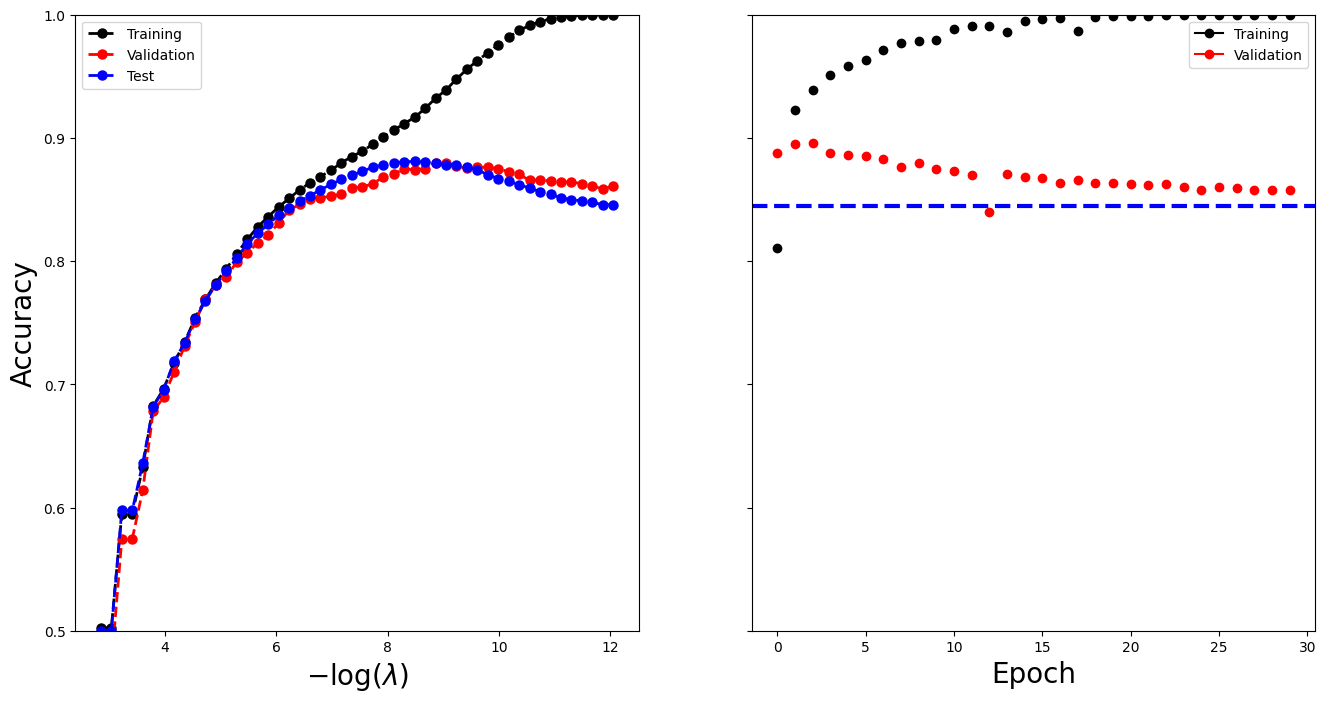

In [ ]:
imdb_results = pd.read_csv(imdb_logger.experiment.metrics_file_path)
summary_plot(imdb_results,
             axes[1],
             col='accuracy',
             ylabel='Accuracy')
axes[1].set_xticks(np.linspace(0, 30, 7).astype(int))
axes[1].set_ylabel('Accuracy', fontsize=20)
axes[1].set_xlabel('Epoch', fontsize=20)
axes[1].set_ylim([0.5, 1]);
axes[1].axhline(test_results[0]['test_accuracy'],
                color='blue',
                linestyle='--',
                linewidth=3)
fig

From the graphs we see that the accuracy of the lasso logistic regression peaks at about $0.88$,  as it does for  the neural network.

Once again, we end with a cleanup.

In [ ]:
del(imdb_model,
    imdb_trainer,
    imdb_logger,
    imdb_dm,
    imdb_train,
    imdb_test)

## Recurrent Neural Networks
In this lab we fit the models illustrated in
Section~\ref{Ch13:sec:recurr-neur-netw}.

### Sequential Models for Document Classification
Here we  fit a simple  LSTM RNN for sentiment prediction to
the `IMDb` movie-review data, as discussed in Section~\ref{Ch13:sec:sequ-models-docum}.
For an RNN we use the sequence of words in a document, taking their
order into account. We loaded the preprocessed 
data at the beginning of
Section~\ref{Ch13-deeplearning-lab:imdb-document-classification}.
A script that details the preprocessing can be found in the
`ISLP` library. Notably, since more than 90% of the documents
had fewer than 500 words, we set the document length to 500. For
longer documents, we used the last 500 words, and for shorter
documents, we padded the front with blanks.


In [ ]:
imdb_seq_dm = SimpleDataModule(imdb_seq_train,
                               imdb_seq_test,
                               validation=2000,
                               batch_size=300,
                               num_workers=min(6, max_num_workers)
                               )


The first layer of the RNN is an embedding layer of size 32, which will be
learned during  training. This layer one-hot encodes  each document
as a matrix of dimension $500 \times 10,003$, and then maps these
$10,003$ dimensions down to $32$. {The extra 3 dimensions
correspond to commonly occurring non-word entries in the reviews.}
 Since each word is represented by an
integer, this is effectively achieved by the creation of an embedding
matrix of size $10,003\times 32$; each of the 500 integers in the
document are then mapped to the appropriate 32 real numbers by
indexing the appropriate rows of this matrix.

The second  layer is an LSTM with 32 units, and the output
layer is a single logit for the binary classification task.
In the last line of the `forward()` method below,
we take the last 32-dimensional output of the LSTM and map it to our response.

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_size, 32)
        self.lstm = nn.LSTM(input_size=32,
                            hidden_size=32,
                            batch_first=True)
        self.dense = nn.Linear(32, 1)
    def forward(self, x):
        val, (h_n, c_n) = self.lstm(self.embedding(x))
        return torch.flatten(self.dense(val[:,-1]))

We instantiate and take a look at the summary of the model, using the
first 10 documents in the corpus.

In [ ]:
lstm_model = LSTMModel(X_test.shape[-1])
summary(lstm_model,
        input_data=imdb_seq_train.tensors[0][:10],
        col_names=['input_size',
                   'output_size',
                   'num_params'])


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
LSTMModel                                [10, 500]                 [10]                      --
├─Embedding: 1-1                         [10, 500]                 [10, 500, 32]             320,096
├─LSTM: 1-2                              [10, 500, 32]             [10, 500, 32]             8,448
├─Linear: 1-3                            [10, 32]                  [10, 1]                   33
Total params: 328,577
Trainable params: 328,577
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 45.44
Input size (MB): 50.00
Forward/backward pass size (MB): 2.56
Params size (MB): 1.31
Estimated Total Size (MB): 53.87

The 10,003 is suppressed in the summary, but we see it in the
parameter count, since $10,003\times 32=320,096$.

In [ ]:
lstm_module = SimpleModule.binary_classification(lstm_model)
lstm_logger = CSVLogger('logs', name='IMDB_LSTM')


In [ ]:
lstm_trainer = Trainer(deterministic=True,
                       max_epochs=20,
                       logger=lstm_logger,
                       enable_progress_bar=False,
                       callbacks=[ErrorTracker()])
lstm_trainer.fit(lstm_module,
                 datamodule=imdb_seq_dm)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | LSTMModel         | 328 K 
1 | loss  | BCEWithLogitsLoss | 0     
--------------------------------------------
328 K     Trainable params
0         Non-trainable params
328 K     Total params
1.314     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=20` reached.


The rest is now similar to other networks we have fit. We
track the test performance as the network is fit, and see that it attains 85% accuracy.

In [ ]:
lstm_trainer.test(lstm_module, datamodule=imdb_seq_dm)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8505200147628784     │
│         test_loss         │    0.7480539679527283     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.7480539679527283, 'test_accuracy': 0.8505200147628784}]

We once again show the learning progress, followed by cleanup.

(0.5, 1.0)

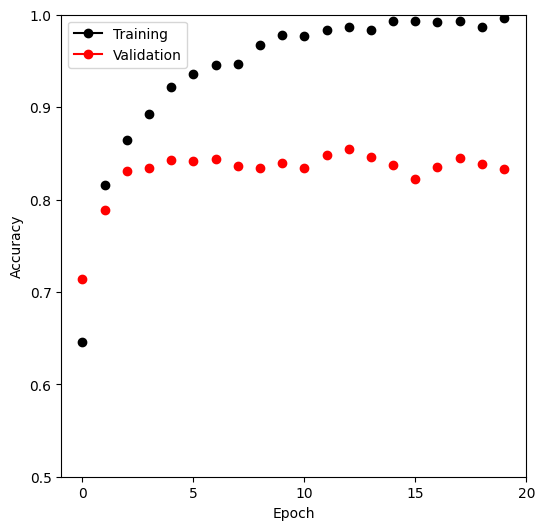

In [ ]:
lstm_results = pd.read_csv(lstm_logger.experiment.metrics_file_path)
fig, ax = subplots(1, 1, figsize=(6, 6))
summary_plot(lstm_results,
             ax,
             col='accuracy',
             ylabel='Accuracy')
ax.set_xticks(np.linspace(0, 20, 5).astype(int))
ax.set_ylabel('Accuracy')
ax.set_ylim([0.5, 1])


In [ ]:
del(lstm_model,
    lstm_trainer,
    lstm_logger,
    imdb_seq_dm,
    imdb_seq_train,
    imdb_seq_test)


### Time Series Prediction
We now show how to fit the models in Section~\ref{Ch13:sec:time-seri-pred}
for  time series prediction.
We first load and standardize the data.

In [ ]:
NYSE = load_data('NYSE')
cols = ['DJ_return', 'log_volume', 'log_volatility']
X = pd.DataFrame(StandardScaler(
                     with_mean=True,
                     with_std=True).fit_transform(NYSE[cols]),
                 columns=NYSE[cols].columns,
                 index=NYSE.index)


Next we set up the lagged versions of the data, dropping
any rows with missing values using the `dropna()`  method.

In [ ]:
for lag in range(1, 6):
    for col in cols:
        newcol = np.zeros(X.shape[0]) * np.nan
        newcol[lag:] = X[col].values[:-lag]
        X.insert(len(X.columns), "{0}_{1}".format(col, lag), newcol)
X.insert(len(X.columns), 'train', NYSE['train'])
X = X.dropna()


Finally, we extract the response, training indicator, and drop the current day’s `DJ_return` and
`log_volatility` to predict only from previous day’s data.

In [ ]:
Y, train = X['log_volume'], X['train']
X = X.drop(columns=['train'] + cols)
X.columns


Index(['DJ_return_1', 'log_volume_1', 'log_volatility_1', 'DJ_return_2',
       'log_volume_2', 'log_volatility_2', 'DJ_return_3', 'log_volume_3',
       'log_volatility_3', 'DJ_return_4', 'log_volume_4', 'log_volatility_4',
       'DJ_return_5', 'log_volume_5', 'log_volatility_5'],
      dtype='object')

We first fit a simple linear model and compute the $R^2$ on the test data using
the `score()`  method.

In [ ]:
M = LinearRegression()
M.fit(X[train], Y[train])
M.score(X[~train], Y[~train])

0.4128912938562521

We refit this model, including the factor variable `day_of_week`.
For a categorical series in `pandas`, we can form the indicators
using the `get_dummies()`  method.

In [ ]:
X_day = pd.concat([X, 
                  pd.get_dummies(NYSE['day_of_week'])],
                  axis=1).dropna()

 Note that we do not have
to reinstantiate the linear regression model
as its `fit()` method accepts a design matrix and a response directly.

In [ ]:
M.fit(X_day[train], Y[train])
M.score(X_day[~train], Y[~train])

0.4595563133053273

This model achieves an $R^2$ of about 46%.

To fit the RNN, we must reshape the data, as it will expect 5 lagged
versions of each feature as indicated by the  `input_shape` argument
to the layer `nn.RNN()`  below. We first
ensure the columns of  our data frame are such that a reshaped
matrix will have the variables correctly lagged. We use the
`reindex()`  method to do this.

For an input shape `(5,3)`, each row represents a lagged version of the three variables.
The `nn.RNN()` layer also expects the first row of each
observation to be earliest in time, so we must reverse the current order.  Hence we loop over
`range(5,0,-1)` below, which is
an example of using a  `slice()`  to index
iterable objects. The general notation is `start:end:step`. 

In [ ]:
ordered_cols = []
for lag in range(5,0,-1):
    for col in cols:
        ordered_cols.append('{0}_{1}'.format(col, lag))
X = X.reindex(columns=ordered_cols)
X.columns


Index(['DJ_return_5', 'log_volume_5', 'log_volatility_5', 'DJ_return_4',
       'log_volume_4', 'log_volatility_4', 'DJ_return_3', 'log_volume_3',
       'log_volatility_3', 'DJ_return_2', 'log_volume_2', 'log_volatility_2',
       'DJ_return_1', 'log_volume_1', 'log_volatility_1'],
      dtype='object')

We now reshape the data.

In [ ]:
X_rnn = X.to_numpy().reshape((-1,5,3))
X_rnn.shape

(6046, 5, 3)

By specifying the first size as -1, `numpy.reshape()` deduces its size based on the remaining arguments.

Now we are ready to proceed with the RNN, which uses 12 hidden units, and  10%
dropout.
After passing through the RNN,  we extract the final time point as `val[:,-1]`
in `forward()` below. This gets passed through a 10% dropout and then flattened through
a linear layer.

In [ ]:
class NYSEModel(nn.Module):
    def __init__(self):
        super(NYSEModel, self).__init__()
        self.rnn = nn.RNN(3,
                          12,
                          batch_first=True)
        self.dense = nn.Linear(12, 1)
        self.dropout = nn.Dropout(0.1)
    def forward(self, x):
        val, h_n = self.rnn(x)
        val = self.dense(self.dropout(val[:,-1]))
        return torch.flatten(val)
nyse_model = NYSEModel()

We  fit the model in a similar fashion to previous networks. We
supply the `fit` function with test data as validation data, so that when
we monitor its progress and plot the history function we can see the
progress on the test data. Of course we should not use this as a basis for
early stopping, since then the test performance would be biased.

We form the training dataset similar to
our `Hitters` example.

In [ ]:
datasets = []
for mask in [train, ~train]:
    X_rnn_t = torch.tensor(X_rnn[mask].astype(np.float32))
    Y_t = torch.tensor(Y[mask].astype(np.float32))
    datasets.append(TensorDataset(X_rnn_t, Y_t))
nyse_train, nyse_test = datasets


Following our usual pattern, we inspect the summary.

In [ ]:
summary(nyse_model,
        input_data=X_rnn_t,
        col_names=['input_size',
                   'output_size',
                   'num_params'])


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
NYSEModel                                [1770, 5, 3]              [1770]                    --
├─RNN: 1-1                               [1770, 5, 3]              [1770, 5, 12]             204
├─Dropout: 1-2                           [1770, 12]                [1770, 12]                --
├─Linear: 1-3                            [1770, 12]                [1770, 1]                 13
Total params: 217
Trainable params: 217
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.83
Input size (MB): 0.11
Forward/backward pass size (MB): 0.86
Params size (MB): 0.00
Estimated Total Size (MB): 0.97

We again put the two datasets into a data module, with a
batch size of 64.

In [ ]:
nyse_dm = SimpleDataModule(nyse_train,
                           nyse_test,
                           num_workers=min(4, max_num_workers),
                           validation=nyse_test,
                           batch_size=64)

We run some data through our model to be sure the sizes match up correctly.

In [ ]:
for idx, (x, y) in enumerate(nyse_dm.train_dataloader()):
    out = nyse_model(x)
    print(y.size(), out.size())
    if idx >= 2:
        break


torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])


We follow our previous example for setting up a trainer for a
regression problem, requesting the $R^2$ metric
to be be computed at each epoch.

In [ ]:
nyse_optimizer = RMSprop(nyse_model.parameters(),
                         lr=0.001)
nyse_module = SimpleModule.regression(nyse_model,
                                      optimizer=nyse_optimizer,
                                      metrics={'r2':R2Score()})


Fitting the model should by now be familiar.
The results on the test data are very similar to the linear AR model. 

In [ ]:
nyse_trainer = Trainer(deterministic=True,
                       max_epochs=200,
                       enable_progress_bar=False,
                       callbacks=[ErrorTracker()])
nyse_trainer.fit(nyse_module,
                 datamodule=nyse_dm)
nyse_trainer.test(nyse_module,
                  datamodule=nyse_dm)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | NYSEModel | 217   
1 | loss  | MSELoss   | 0     
------------------------------------
217       Trainable params
0         Non-trainable params
217       Total params
0.001     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=200` reached.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     0.616382360458374     │
│          test_r2          │    0.4150230884552002     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.616382360458374, 'test_r2': 0.4150230884552002}]

We could also fit a model without the `nn.RNN()` layer by just
using a `nn.Flatten()` layer instead. This would be a nonlinear AR model. If in addition we excluded the 
hidden layer, this would be equivalent to our earlier linear AR model.  

Instead we will fit a nonlinear AR model using the feature set `X_day` that includes the `day_of_week` indicators.
To do so, we
must first create our test and training datasets and a corresponding
data module. This may seem a little burdensome, but is part of the
general pipeline for `torch`.

In [ ]:
datasets = []
for mask in [train, ~train]:
    X_day_t = torch.tensor(
                   np.asarray(X_day[mask]).astype(np.float32))
    Y_t = torch.tensor(np.asarray(Y[mask]).astype(np.float32))
    datasets.append(TensorDataset(X_day_t, Y_t))
day_train, day_test = datasets

Creating a data module follows a familiar pattern.

In [ ]:
day_dm = SimpleDataModule(day_train,
                          day_test,
                          num_workers=min(4, max_num_workers),
                          validation=day_test,
                          batch_size=64)


We build a `NonLinearARModel()` that takes as input the 20 features and a hidden layer  with 32 units. The remaining steps are familiar.

In [ ]:
class NonLinearARModel(nn.Module):
    def __init__(self):
        super(NonLinearARModel, self).__init__()
        self._forward = nn.Sequential(nn.Flatten(),
                                      nn.Linear(20, 32),
                                      nn.ReLU(),
                                      nn.Dropout(0.5),
                                      nn.Linear(32, 1))
    def forward(self, x):
        return torch.flatten(self._forward(x))


In [ ]:
nl_model = NonLinearARModel()
nl_optimizer = RMSprop(nl_model.parameters(),
                           lr=0.001)
nl_module = SimpleModule.regression(nl_model,
                                        optimizer=nl_optimizer,
                                        metrics={'r2':R2Score()})


We continue with the usual training steps, fit the model,
and evaluate the test error. We see the test $R^2$ is a slight improvement over the linear AR model that also includes `day_of_week`.

In [ ]:
nl_trainer = Trainer(deterministic=True,
                     max_epochs=20,
                     enable_progress_bar=False,
                     callbacks=[ErrorTracker()])
nl_trainer.fit(nl_module, datamodule=day_dm)
nl_trainer.test(nl_module, datamodule=day_dm) 

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params
-------------------------------------------
0 | model | NonLinearARModel | 705   
1 | loss  | MSELoss          | 0     
-------------------------------------------
705       Trainable params
0         Non-trainable params
705       Total params
0.003     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=20` reached.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5626183152198792     │
│          test_r2          │    0.4660477638244629     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5626183152198792, 'test_r2': 0.4660477638244629}]